# Time Series classification of Aerodynamics
The boundary layer on an airfoil can be in two states, Laminar or Turbulent. Visually this switch is quite easy to see, for the aerodynamics muggles, the turbulent boundary layer state with show up on the time series data from the microphone as very turbulent(or volatile if you are from the finance world). 
Other ways to solve this problem include
- Traditional signal processing tricks that can extract such a change over of course. 
- Bayesian switch point analysis with a flexible number of switch points would also work. 
- The auto-regressive type models<br>
But I wanted to try my hand at getting a time series model in torch working, so here we are. 

In [150]:
import torch 
import pickle
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set up Model
One layer LSTM to multi layer fully conencted.
Sigmoid on the out layer as it is a classification problem. 
More layers can be enabled but 91% Validation error is possible with our the second lstm and extra fc layers. 

In [151]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
        self.Sig = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        #input.view(self.input_dim, self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(input.view(-1,len(input),6))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.Sig(self.linear(lstm_out[-1].view(len(input), -1)))
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)


# Read in data
The features of the time series have been pre-processed to include the time series itself and the first 5 mel-spectrum coefficients. 
!!! Need to double check for data leakage in the mel-spectrum coefficients 

In [161]:
df = pd.read_pickle("Reduced.pkl")
Split = 0.8
SplitInd = int(Split * len(df))
LabelList = ['ts',*range(5)]
Input = torch.tensor(df[LabelList].values)
Output = torch.tensor(df['Labels'].values)

#load second file hacky way for now. Only two files needed for training set.  
df3 = pd.read_pickle("Reduced3.pkl")

Input3 = torch.tensor(df3[LabelList].values)
Output3 = torch.tensor(df3['Labels'].values)

df4 = pd.read_pickle("Sensor0-Copy1")
df4.Labels = 1

Input4 = torch.tensor(df4[LabelList].values)
Output4 = torch.tensor(df4['Labels'].values)


#Valid trainSplit
InpTrain4, InpValid4 = Input4[:SplitInd], Input4[SplitInd:]
OutTrain4, OutValid4 = Output4[:SplitInd], Output4[SplitInd:]


#Valid trainSplit
InpTrain, InpValid = Input[:SplitInd], Input[SplitInd:]
OutTrain, OutValid = Output[:SplitInd], Output[SplitInd:]

#Valid trainSplit
InpTrain3, InpValid3 = Input3[:SplitInd], Input3[SplitInd:]
OutTrain3, OutValid3 = Output3[:SplitInd], Output3[SplitInd:]

#Concat two files. 
InputTrain = torch.cat((InpTrain,InpTrain3,InpTrain4),0)
InputValid = torch.cat((InpValid,InpValid3,InpValid4),0)
OutputTrain = torch.cat((OutTrain,OutTrain3,OutTrain4),0)
OutputValid = torch.cat((OutValid,OutValid3,OutValid4),0)

#Train scaler on training data only. No peeking now!! 
InpScaler = StandardScaler()
InpScaler.fit(InpTrain)



InpTrain = torch.tensor(InpScaler.transform(InpTrain))
InpValid = torch.tensor(InpScaler.transform(InpValid))

BatchSize = 200000
#Into DataLoaders
# Large Batch size seems to perform better. 
TrainDataSet = torch.utils.data.TensorDataset(InpTrain, OutTrain)
Train = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)

ValidDataSet = torch.utils.data.TensorDataset(InpValid, OutValid)
Valid = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)
LenTrain = len(InpTrain)
LenValid = len(InpValid)

In [4]:
with open('scaler.pickle', 'wb') as file:
    pickle.dump(InpScaler,file)

# Initiate with Simple paralell architecture 

In [172]:
model = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=10)
model.cuda()

Classifier(
  (lstm): LSTM(6, 6, num_layers=10)
  (linear): Linear(in_features=6, out_features=1, bias=True)
  (Sig): Sigmoid()
)

# Simple SGD optimizer
Achieved 91% without momentum, Cosine Annealing appears effective from training. 
Have to implement a LR finder to better set. Works for now, probably go achieve much faster training

In [262]:
lr = 1e-1
#optimizer = torch.optim.SGD(model.parameters(),lr,momentum = 0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,10,0.1*lr)

batch
batch
epoch0
train loss: 104.5006103515625
regular: 0.0009178657201118767
Learning Rate:[0.09779754323328191]
batch
batch
epoch1
train loss: 2.0000393390655518
regular: 2.9151347916922532e-05
Learning Rate:[0.1]
batch
batch
epoch2
train loss: 3.061011739191599e-05
regular: 0.02104768715798855
valid loss: 2.924263935710769e-05
accuracy: 67.18400120735168 %
saved


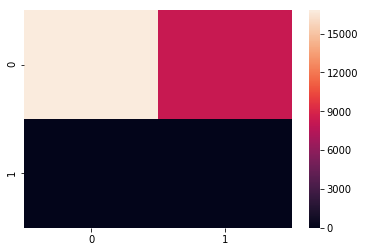

Learning Rate:[0.09779754323328191]
batch
batch
epoch3
train loss: 3.0223263820516877e-05
regular: 0.18030212819576263
valid loss: 3.067026409553364e-05
accuracy: 67.18400120735168 %


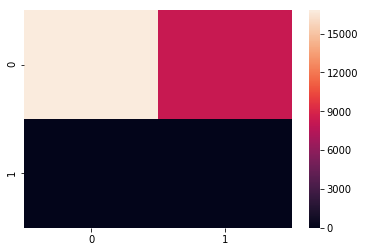

Learning Rate:[0.09140576474687265]
batch
batch
epoch4
train loss: 3.1712068448541686e-05
regular: 0.06937405467033386
valid loss: 3.178391125402413e-05
accuracy: 32.815998792648315 %


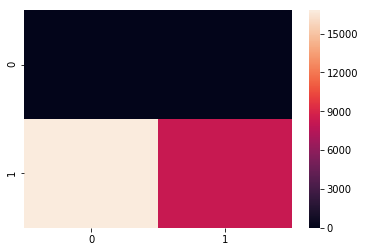

Learning Rate:[0.08145033635316129]
batch
batch
epoch5
train loss: 3.1994197343010455e-05
regular: 0.006141946651041508
valid loss: 3.157352330163121e-05
accuracy: 32.815998792648315 %


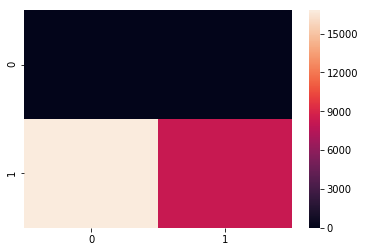

Learning Rate:[0.06890576474687263]
batch
batch
epoch6
train loss: 3.1397066777572036e-05
regular: 0.0018925924086943269
valid loss: 3.0933635571273044e-05
accuracy: 67.18400120735168 %


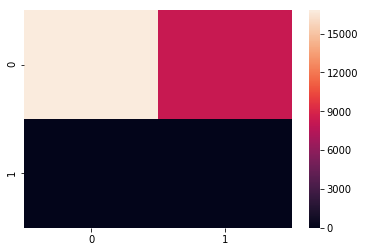

Learning Rate:[0.055]
batch
batch
epoch7
train loss: 3.0732488085050136e-05
regular: 0.001808186643756926
valid loss: 3.042202297365293e-05
accuracy: 67.18400120735168 %


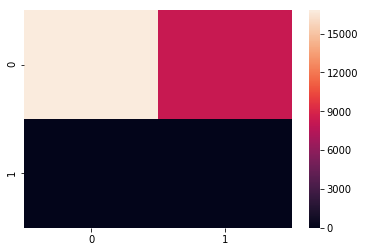

Learning Rate:[0.04109423525312737]
batch
batch
epoch8
train loss: 3.0298328056233004e-05
regular: 0.0017518308013677597
valid loss: 3.0129414881230332e-05
accuracy: 67.18400120735168 %


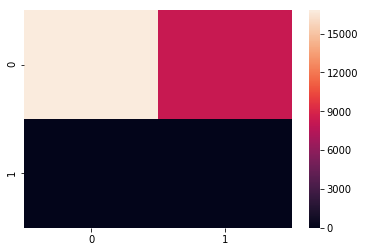

Learning Rate:[0.028549663646838714]
batch
batch
epoch9
train loss: 3.006987026310526e-05
regular: 0.001781167578883469
valid loss: 2.9985327273607254e-05
accuracy: 67.18400120735168 %


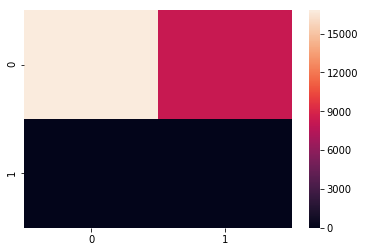

Learning Rate:[0.018594235253127374]
batch
batch
epoch10
train loss: 2.995982504216954e-05
regular: 0.0018621617928147316
valid loss: 2.9916542189312167e-05
accuracy: 67.18400120735168 %


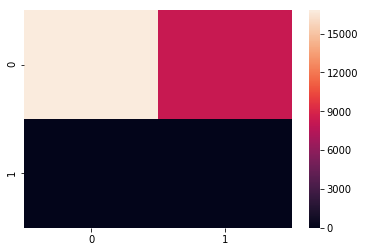

Learning Rate:[0.012202456766718092]
batch
batch
epoch11
train loss: 2.990548819070682e-05
regular: 0.0019495936576277018
valid loss: 2.9877548513468355e-05
accuracy: 67.18400120735168 %


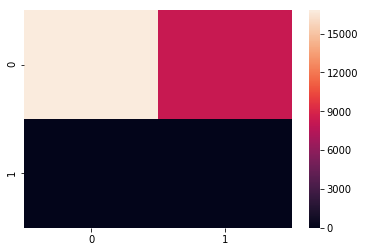

Learning Rate:[0.010000000000000002]
batch
batch
epoch12
train loss: 2.9874505344196223e-05
regular: 0.0020533264614641666
valid loss: 2.9847737096133642e-05
accuracy: 67.18400120735168 %


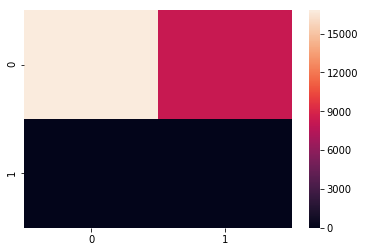

Learning Rate:[0.012202456766718084]
batch
batch
epoch13
train loss: 2.9856868422939442e-05
regular: 0.0022162403911352158
valid loss: 2.9825074307154864e-05
accuracy: 67.18400120735168 %


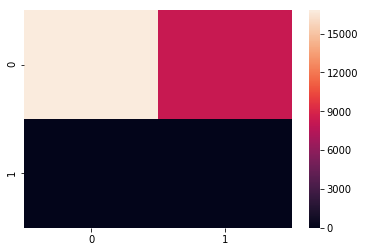

Learning Rate:[0.01859423525312736]
batch
batch
epoch14
train loss: 2.9857217668904923e-05
regular: 0.0024930236395448446
valid loss: 2.98189370369073e-05
accuracy: 67.18400120735168 %


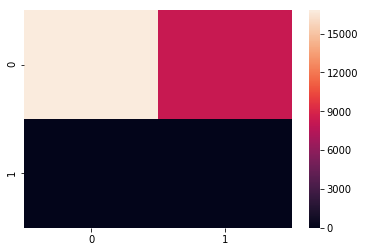

Learning Rate:[0.028549663646838704]
batch
batch
epoch15
train loss: 2.9886821721447632e-05
regular: 0.0029072167817503214
valid loss: 2.9841368814231828e-05
accuracy: 67.18400120735168 %


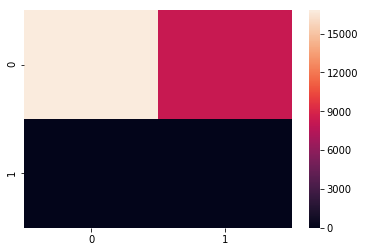

Learning Rate:[0.04109423525312736]
batch
batch
epoch16
train loss: 2.9953373086755164e-05
regular: 0.003283978905528784
valid loss: 2.9895758416387253e-05
accuracy: 67.18400120735168 %


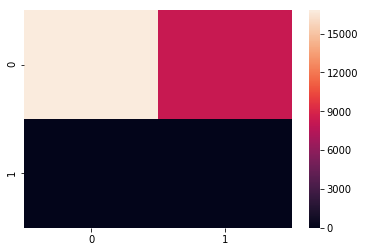

Learning Rate:[0.05499999999999999]
batch
batch
epoch17
train loss: 3.0047141990507953e-05
regular: 0.0034628703724592924
valid loss: 2.9961191103211604e-05
accuracy: 67.18400120735168 %


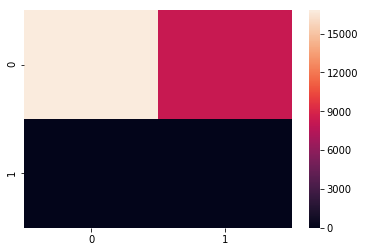

Learning Rate:[0.06890576474687263]
batch
batch
epoch18
train loss: 3.0124259865260683e-05
regular: 0.0050690192729234695
valid loss: 2.9980648832861334e-05
accuracy: 67.18400120735168 %


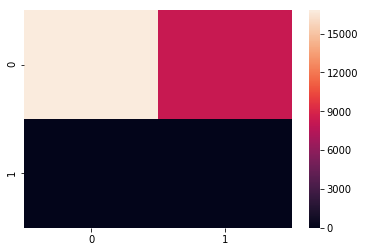

Learning Rate:[0.08145033635316129]
batch
batch
epoch19
train loss: 3.012121669598855e-05
regular: 0.008316216059029102
valid loss: 2.990496977872681e-05
accuracy: 67.18400120735168 %


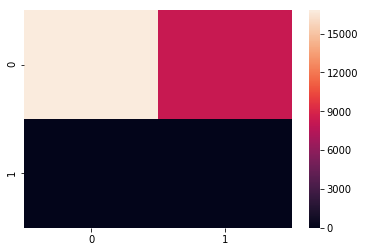

Learning Rate:[0.09140576474687265]
batch
batch
epoch20
train loss: 2.9994438591529615e-05
regular: 0.015572592616081238
valid loss: 2.970226159959566e-05
accuracy: 67.18400120735168 %


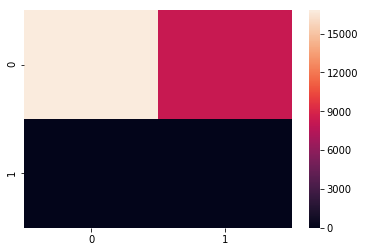

Learning Rate:[0.09779754323328191]
batch
batch
epoch21
train loss: 2.9736358555965126e-05
regular: 0.0523410439491272
valid loss: 2.9400220228126273e-05
accuracy: 67.18400120735168 %


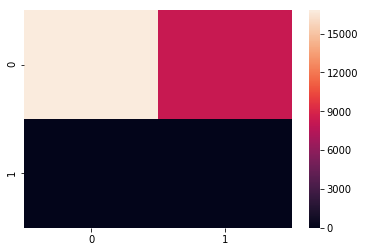

Learning Rate:[0.1]
batch
batch
epoch22
train loss: 2.9391034331638366e-05
regular: 0.11666012555360794
valid loss: 2.902204323618207e-05
accuracy: 67.18400120735168 %


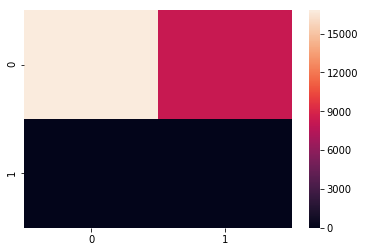

Learning Rate:[0.09779754323328191]
batch
batch
epoch23
train loss: 2.898352249758318e-05
regular: 0.1502869427204132
valid loss: 2.854763442883268e-05
accuracy: 67.18400120735168 %


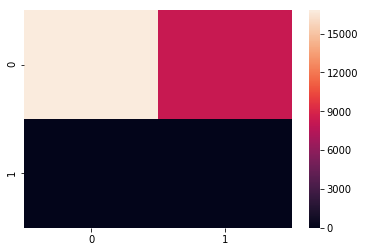

Learning Rate:[0.09140576474687268]
batch
batch
epoch24
train loss: 2.8473945349105634e-05
regular: 0.26440203189849854
valid loss: 2.796891021716874e-05
accuracy: 67.18400120735168 %


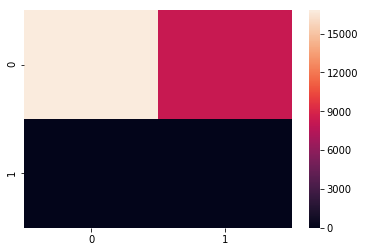

Learning Rate:[0.08145033635316129]
batch
batch
epoch25
train loss: 2.7823192795040086e-05
regular: 0.5921847224235535
valid loss: 2.7285475880489685e-05
accuracy: 67.18400120735168 %


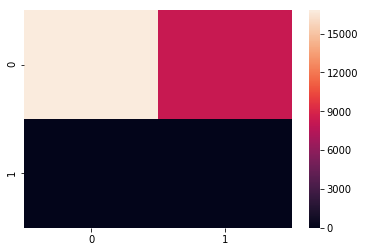

Learning Rate:[0.06890576474687266]
batch
batch
epoch26
train loss: 576.0230712890625
regular: 1.235451579093933
valid loss: 1095.0323486328125
accuracy: 91.73599481582642 %
saved


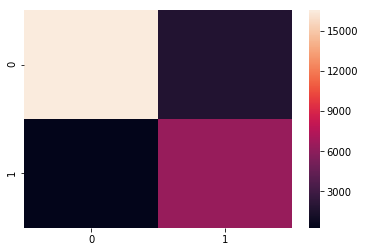

Learning Rate:[0.05500000000000001]
batch
batch
epoch27
train loss: 1223.0374755859375
regular: 3.008112668991089
valid loss: 1108.032470703125
accuracy: 91.37600064277649 %


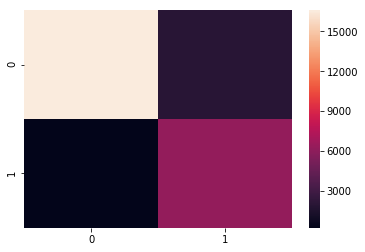

Learning Rate:[0.04109423525312738]
batch
batch
epoch28
train loss: 1044.02978515625
regular: 5.04916524887085
valid loss: 1215.5362548828125
accuracy: 91.51600003242493 %


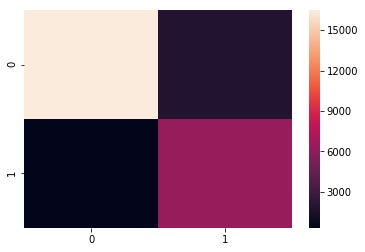

Learning Rate:[0.02854966364683872]
batch
batch
epoch29
train loss: 1375.5426025390625
regular: 7.67499303817749
valid loss: 1643.05419921875
accuracy: 91.08799695968628 %


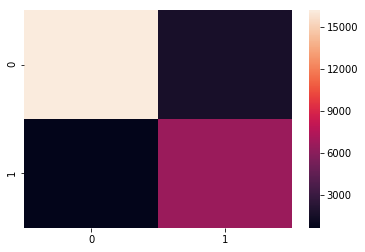

Learning Rate:[0.018594235253127374]
batch
batch
epoch30
train loss: 1643.05419921875
regular: 10.782562255859375
valid loss: 1851.06298828125
accuracy: 91.01199507713318 %


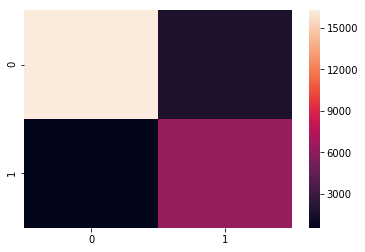

Learning Rate:[0.012202456766718097]
batch
batch
epoch31
train loss: 1627.0540771484375
regular: 13.158318519592285
valid loss: 1585.552734375
accuracy: 90.76799750328064 %


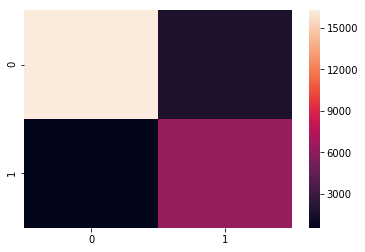

Learning Rate:[0.010000000000000002]
batch
batch
epoch32
train loss: 1649.55517578125
regular: 14.381281852722168
valid loss: 1841.5618896484375
accuracy: 90.81599712371826 %


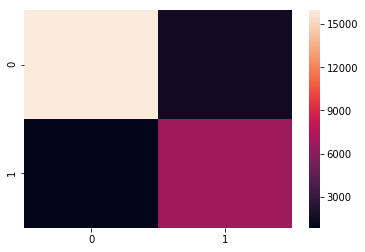

Learning Rate:[0.012202456766718089]
batch
batch
epoch33
train loss: 1937.565673828125
regular: 17.40676498413086
valid loss: 1505.050048828125
accuracy: 91.22399687767029 %


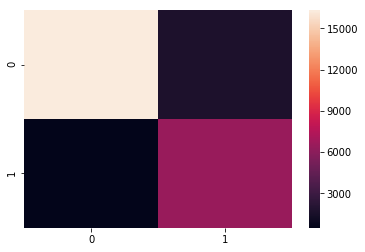

Learning Rate:[0.018594235253127357]
batch
batch
epoch34
train loss: 1089.033447265625
regular: 17.445070266723633
valid loss: 1160.034912109375
accuracy: 91.6599988937378 %


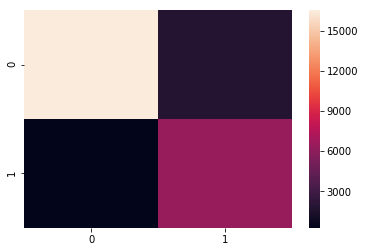

Learning Rate:[0.028549663646838697]
batch
batch
epoch35
train loss: 1320.041259765625
regular: 25.919614791870117
valid loss: 1458.04638671875
accuracy: 91.75999760627747 %
saved


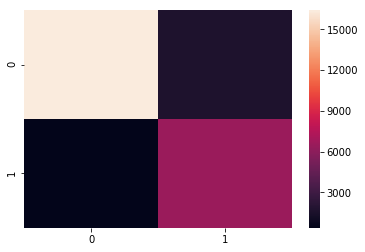

Learning Rate:[0.041094235253127345]
batch
batch
epoch36
train loss: 1138.03369140625
regular: 37.37180709838867
valid loss: 1295.541259765625
accuracy: 92.10799932479858 %
saved


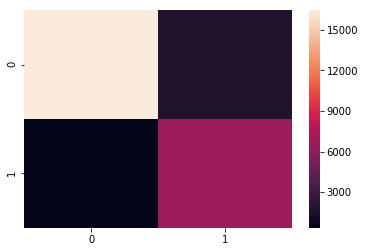

Learning Rate:[0.05499999999999998]
batch
batch
epoch37
train loss: 1039.531005859375
regular: 57.142234802246094
valid loss: 2392.5859375
accuracy: 88.291996717453 %


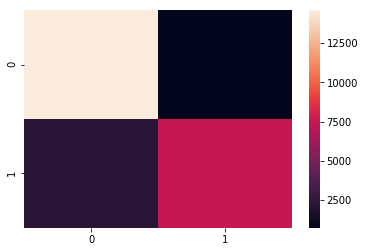

Learning Rate:[0.06890576474687261]
batch
batch
epoch38
train loss: 728.519287109375
regular: 72.78703308105469
valid loss: 589.016357421875
accuracy: 90.07200002670288 %


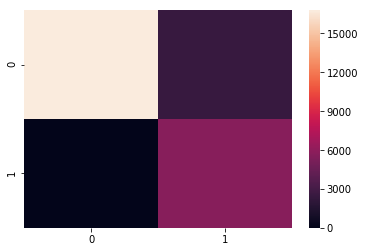

Learning Rate:[0.08145033635316129]
batch
batch
epoch39
train loss: 685.0202026367188
regular: 146.56683349609375
valid loss: 845.0243530273438
accuracy: 89.44399952888489 %


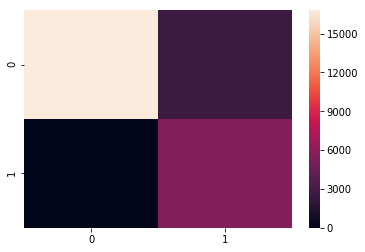

Learning Rate:[0.09140576474687262]
batch
batch
epoch40
train loss: 685.0179443359375
regular: 160.38551330566406
valid loss: 543.5150146484375
accuracy: 89.4599974155426 %


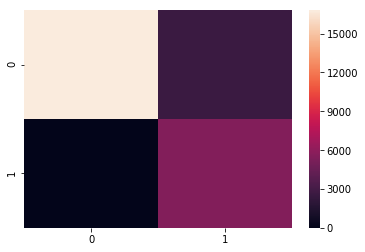

Learning Rate:[0.09779754323328191]
batch
batch
epoch41
train loss: 543.5150146484375
regular: 149.36244201660156
valid loss: 641.5189208984375
accuracy: 89.55999612808228 %


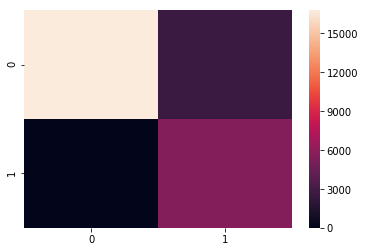

Learning Rate:[0.1]
batch
batch
epoch42
train loss: 641.5189208984375
regular: 208.41177368164062
valid loss: 763.5228271484375
accuracy: 89.99599814414978 %


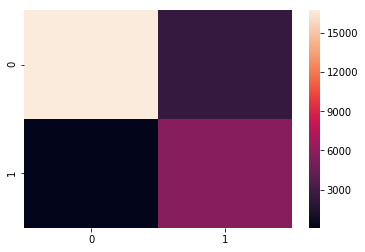

Learning Rate:[0.09779754323328194]
batch
batch
epoch43
train loss: 859.526611328125
regular: 284.7696838378906
valid loss: 914.5291748046875
accuracy: 89.93600010871887 %


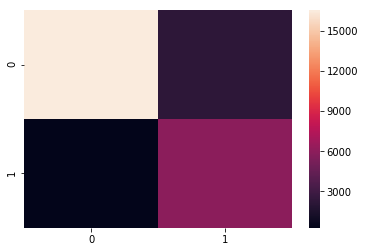

Learning Rate:[0.09140576474687265]
batch
batch
epoch44
train loss: 1074.5355224609375
regular: 354.33160400390625
valid loss: 853.5277709960938
accuracy: 90.06399512290955 %


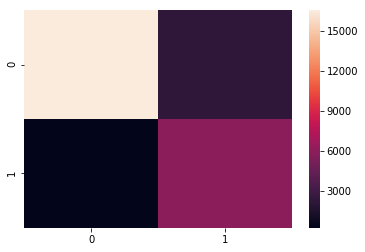

Learning Rate:[0.08145033635316132]
batch
batch
epoch45
train loss: 789.5252075195312
regular: 282.6605529785156
valid loss: 749.0238647460938
accuracy: 90.09199738502502 %


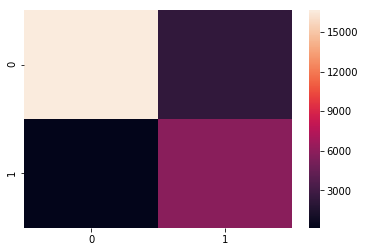

Learning Rate:[0.06890576474687274]
batch
batch
epoch46
train loss: 749.0238647460938
regular: 273.16021728515625
valid loss: 608.0186767578125
accuracy: 90.1639997959137 %


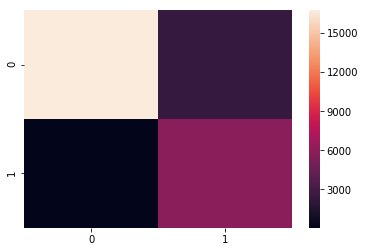

Learning Rate:[0.05500000000000002]
batch
batch
epoch47
train loss: 608.0186767578125
regular: 225.9371795654297
valid loss: 575.0174560546875
accuracy: 89.99999761581421 %


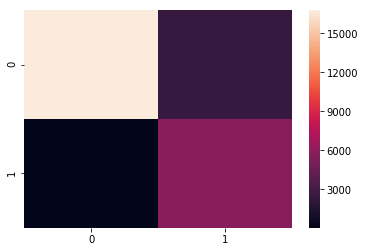

Learning Rate:[0.04109423525312739]
batch
batch
epoch48
train loss: 575.0174560546875
regular: 216.9928741455078
valid loss: 612.0187377929688
accuracy: 90.01999497413635 %


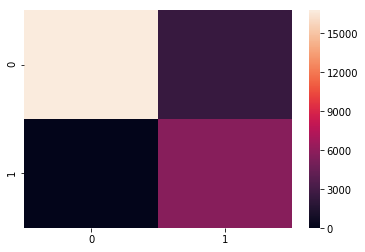

Learning Rate:[0.028549663646838665]
batch
batch
epoch49
train loss: 612.0187377929688
regular: 229.72503662109375
valid loss: 615.0187377929688
accuracy: 90.0879979133606 %


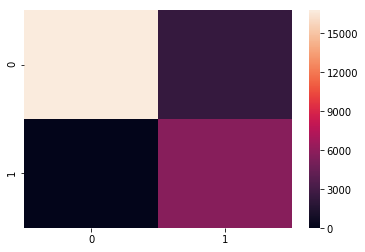

Learning Rate:[0.01859423525312738]


In [263]:
# Training Loop 
%matplotlib inline
highest = 0
regular = 1e10
for k in range(50):
    
    running_loss= 0 
    corrects = 0
    #Train
    for inp, target in Train:
        optimizer.zero_grad()
        inp = inp.cuda()
        print('batch')
        output = model.forward(inp.float())
        #train
        Thresholded = torch.gt(output.float(),torch.tensor([0.5]).float().cuda()).float()
        loss = nn.functional.binary_cross_entropy(output, target.float().cuda()) + regular*torch.nn.functional.mse_loss(Conv(Thresholded.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda()) 
        #loss = CrossEntropy(output, target.float().reshape(output.shape).cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss/len(target)  
    if k % 1==0: 
        print("epoch{}".format(k))
        print("train loss: {}".format(running_loss))
        print("regular: {}".format(regular*torch.nn.functional.mse_loss(Conv(output.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda()) 
/len(target)))
    running_loss= 0 
    # Added the option of just running the Training step for the first few epochs.
    if k > 1:
        # Validate. 
        for inp, target in Valid:
            inp = inp.cuda()
            output = model.forward(inp.float())
            Thresholded = torch.gt(output,torch.tensor([0.5]).float().cuda()).float()
            #valid
            loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) + regular*torch.nn.functional.mse_loss(Conv(Thresholded.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda())
            #Track Epoch Loss
            running_loss += loss/len(target)
            a = (output>0.5) 
            b= target.reshape(output.shape).cuda()>0.5 
        
        #Print out. 
        if k % 1 ==0: 
            print("valid loss: {}".format(running_loss))
            print("accuracy: {} %".format((a==b).float().mean().item()*100))
            if ((a==b).float().mean().item()*100)> highest:
                highest = ((a==b).float().mean().item()*100)
                #Save out model that achieves best accuracy. 
                torch.save(model.state_dict(), './ModelSave3.pt')
                print("saved")
            plt.figure()    
            sns.heatmap(confusion_matrix(a.cpu().numpy(),b.cpu().numpy()))
            plt.show()
            
    print("Learning Rate:{}".format(scheduler.get_lr()))
    scheduler.step() 

None


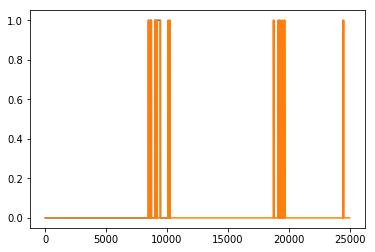

In [264]:
print(loss.grad)
plt.figure()
plt.plot(Thresholded.detach().cpu().numpy()[:10000])
plt.plot(Conv(Thresholded.reshape([1,1,output.shape[0]])).cpu().detach().numpy().flatten()**2)

In [155]:
from matplotlib.lines import Line2D   
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
plot_grad_flow(model.named_parameters())

AttributeError: 'NoneType' object has no attribute 'abs'

In [23]:
named_parameters = model.named_parameters()
ave_grads = []
layers = []
for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())

AttributeError: 'NoneType' object has no attribute 'abs'

In [24]:
type(p)
n

'layer2.weight'

model.named_parameters


# Evaluate Model
 Load up the best performing model. Run the model and Plot the results. 

In [265]:
model2 = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=10)
model2.load_state_dict(torch.load('./ModelSave3.pt'))
model2.cuda()

df = pd.read_pickle("Reduced.pkl")
df3 = pd.read_pickle("Reduced3.pkl")
df = df.append(df3)
df = df.append(df4.drop('time',axis=1),sort=True)
#Load into Torch Dataset. 
Input = torch.tensor(InpScaler.transform(df[LabelList].values))
Output = torch.tensor(df['Labels'].values)

MainDataSet = torch.utils.data.TensorDataset(Input, Output)
Main = torch.utils.data.DataLoader(MainDataSet,batch_size = 200000,num_workers = 1)
full_results = torch.Tensor()
#Run Model over the batches. 
for inp, Label in Main:
    inp = inp.cuda()
    output = model2.forward(inp.float())

    full_results = torch.cat((full_results,output.cpu()),0)

In [239]:
#Confusion Plot. 
plt.figure()

full_results[:,-2] = full_results[:,-2]>0.5
sns.heatmap(confusion_matrix(full_results[:,-2].detach().numpy(),full_results[:,-1].detach().numpy()))
plt.show()

IndexError: too many indices for tensor of dimension 1

<Figure size 432x288 with 0 Axes>

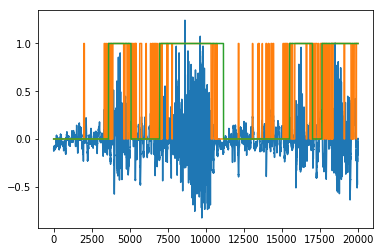

In [268]:
#Time Series
%matplotlib inline
plt.figure()
#plt.plot(full_results[:,-1].detach().numpy())
#plt.plot(full_results[:,-2].detach().numpy())

plt.plot(df['ts'].values[:20000])
plt.plot(full_results.detach().numpy()[:20000]>0.5)
plt.plot(df['Labels'].values[:20000])

plt.show()

In [112]:
full_results.shape


torch.Size([843750])

In [113]:
df

,ts,Labels,0,1,2,3,4,5
0,-0.100506,0,-0.017518,0.001688,0.000334,0.000028,-0.000025,0.000065
16,-0.112558,0,-0.017520,0.001688,0.000334,0.000028,-0.000025,0.000065
32,-0.122963,0,-0.017525,0.001688,0.000334,0.000028,-0.000025,0.000065
48,-0.124815,0,-0.017534,0.001687,0.000334,0.000028,-0.000025,0.000065
64,-0.114058,0,-0.017546,0.001687,0.000334,0.000028,-0.000025,0.000065
80,-0.106800,0,-0.017562,0.001687,0.000334,0.000028,-0.000025,0.000065
96,-0.111124,0,-0.017581,0.001686,0.000334,0.000028,-0.000025,0.000065
112,-0.109121,0,-0.017603,0.001686,0.000334,0.000028,-0.000025,0.000065
128,-0.103176,0,-0.017627,0.001685,0.000334,0.000028,-0.000025,0.000065
144,-0.101728,0,-0.017655,0.001684,0.000334,0.000028,-0.000025,0.000065
